In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rfest import GLM
from rfest.utils import fetch_data, split_data

# What is a receptive field?

## Earliest RFs

A 2D surface (thus, "field") which receives stimuli (thus, "receptive").

Sherrington (1906) | Hartline (1938, 1940)
- | - 
![sherrington](./img/sherrington-dog-rf-1906.png) | ![hartline](./img/hartline-rf-1940.png)

## Modern RFs

Modern RFs are beyond 2D surfaces and most often defined functionally as the optimal stimulus patterns that drive a neuron to spike.

# 1D RF Example (Uzzell & Chichilnisky, 2004)

In [2]:
data1d = fetch_data(data=3, datapath='./data/')
X = data1d['Stim'] # full field flicker 
X

(Uzzell & Chichilnisky, 2004) is already downloaded. To re-download the same file, please set `overwrite=False`.
Loading data...
Done.


array([-0.48,  0.48,  0.48, ...,  0.48,  0.48,  0.48])

### Visualize the Full-Field Flicker stimulus

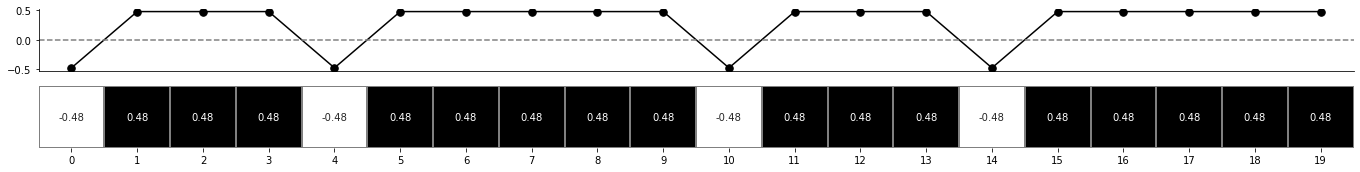

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(19, 2.5))
sns.heatmap(X[:20, None].T, annot=True, cmap='binary', linewidths=1, linecolor='gray', cbar=False, 
            ax=ax[1], xticklabels=True, yticklabels=False)
ax[0].plot(np.arange(20), X[:20], color='black', marker='.', markersize=15)

# just for aesthetics
ax[0].axhline(0, color='gray', linestyle='--')
ax[0].set_xlim(-0.5, 19.5)
ax[0].set_xticks([])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
fig.tight_layout()

In [79]:
def convert_stim1d(X, dims):
    
    '''
    Helper function for turning an array of Full-Field Flicker into "images". 
    '''
    
    if len(X.shape) == 1:
        X = X[:, None] # convert a row vector into a column vector
        
    n_samples = X.shape[0]
    X_addx = np.repeat(X, dims[0], axis=0).reshape(n_samples, dims[0])
    X_addy = np.repeat(X_addx, dims[1], axis=1).reshape(n_samples, dims[0], dims[1])
    
    return X_addy    

def animate(data, dt=0.033, reverse=False, cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2, save_to=False, figsize=(6, 6)):
    
    '''
    Helper function for turning a stimulus into a video
    '''
    
    from IPython.display import HTML
    import matplotlib.animation as animation
    dims = data.shape
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    n_samples = data.shape[0]
    im = ax.imshow(data[0,:,:].T, cmap=cmap, vmin=vmin, vmax=vmax)
    if reverse:
        tt = -np.arange(0, n_samples, 1)[::-1] * dt
    else:
        tt = np.arange(0, n_samples, 1) * dt
    ax.set_title(f't={tt[0]:.02f} s')
    ax.set_xticks([])
    ax.set_yticks([])
    def init():
        im.set_data(data[0,:,:].T)
        return im
    
    # animation function. This is called sequentially
    def animate(j):
        data_slice = data[j,:,:].T
        ax.set_title(f't={tt[j]:.02f} s')
        im.set_data(data_slice)
        
        return im
    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=dims[0], interval=dt*1000, blit=False)
    if save_to is not False:
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=1/dt, metadata=dict(artist='Me'), bitrate=1800)
        anim.save(save_to, writer=writer)
    plt.close()
    return HTML(anim.to_html5_video())

In [5]:
Ximg = convert_stim1d(X, dims=[10, 10])

In [6]:
# animate the first 20 frames of the full field flicker
animate(Ximg[:20], dt=0.25, cmap=plt.cm.binary, reverse=False)

In [7]:
stimtime = data1d['stimtimes'].flatten()
spiketime = np.squeeze(data1d['SpTimes'])[2]
dt = stimtime[1] - stimtime[0] # refresh rate of the stimulus in seconds
dt

0.008340605

In [8]:
# # play the stimulus in the speed of the data.
# # but make sure that you don't have a medical history of photosensitive epilepsy
# animate(Ximg[:20], dt=dt, cmap=plt.cm.binary, reverse=False)

In [9]:
X.shape, stimtime.shape, spiketime.shape

((144051,), (144051,), (49954, 1))

### Visualzing the response

In [10]:
spiketime.flatten()[:10] # spike time in seconds

array([0.04895939, 0.0522594 , 0.05730939, 0.0620094 , 0.0855094 ,
       0.0881094 , 0.0915594 , 0.0944594 , 0.12730939, 0.1310594 ])

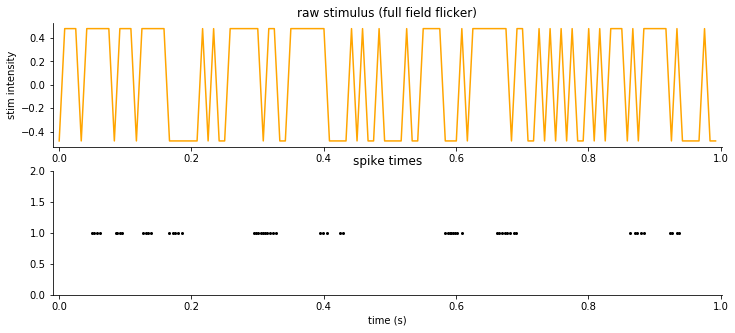

In [11]:
fig, ax = plt.subplots(2,1 ,figsize=(12, 5))
iiplot = np.arange(120) # bins of stimulus to plot
ttplot = iiplot*dt  # time bins of stimulus
ax[0].plot(ttplot,X[iiplot], color='orange')
ax[0].set_title('raw stimulus (full field flicker)')
ax[0].set_ylabel('stim intensity')

tspplot = spiketime[(spiketime>=ttplot[0])&(spiketime<ttplot[-1])]
ax[1].plot(tspplot, [1]*len(tspplot), 'ko', markersize=2)
ax[1].set_xlim([ttplot[0], ttplot[-1]]); plt.ylim([0,2])
ax[1].set_title('spike times')
ax[1].set_xlabel('time (s)')

for i in range(2):
    ax[i].set_xlim([ttplot[0]-0.01, ttplot[-1]+0.01]); plt.ylim([0,2])
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

In [12]:
# the shape of the stimulus and the spiketime is not the same
# we need them to be in the same shape

(X.shape == spiketime.shape), X.shape, spiketime.shape

(False, (144051,), (49954, 1))

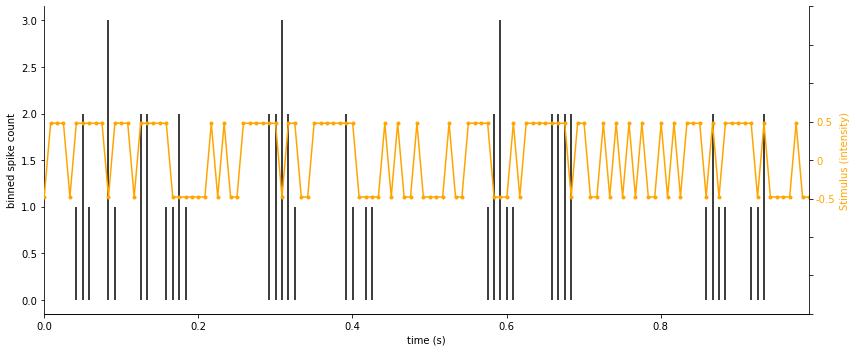

In [13]:
### bin the spike times using np.histogram
### so that X (the stimulu) and y (the spike counts) will be in the same shape

n_samples = len(X)
tbins = np.arange(n_samples+1)*dt     # time bin centers for spike train binnning
y,_ = np.histogram(spiketime,tbins)     # binned spike train

### Replot the responses we'll putting into our regression as counts
fig, ax = plt.subplots(figsize=(12, 5))
markerline, stemlines, baseline = ax.stem(ttplot,y[iiplot], linefmt='black', markerfmt='none', use_line_collection=True,)
markerline.set_markerfacecolor('none')
plt.setp(baseline, 'color', 'none')
ax.set_ylabel('binned spike count')
ax.set_xlabel('time (s)')
ax.set_xlim([ttplot[0], ttplot[-1]])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax2 = ax.twinx()
ax2.plot(ttplot,X[iiplot], color='orange', marker='.')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_yticklabels([None, None, None, -0.5, 0, 0.5, None, None, None])
ax2.set_ylabel('Stimulus (intensity)', color='orange')
ax2.set_ylim(-2, 2)


fig.tight_layout()

In [14]:
(X.shape == y.shape), X.shape, y.shape

(True, (144051,), (144051,))

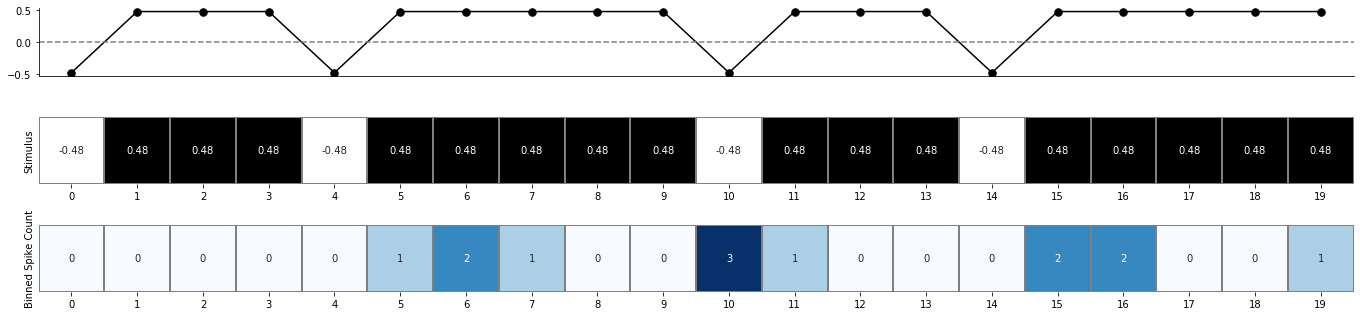

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(19, 4.5))

ax[0].plot(np.arange(20), X[:20], color='black', marker='.', markersize=15)

# just for aesthetics
ax[0].axhline(0, color='gray', linestyle='--')
ax[0].set_xlim(-0.5, 19.5)
ax[0].set_xticks([])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

sns.heatmap(X[:20, None].T, annot=True, cmap='binary', linewidths=1, linecolor='gray', cbar=False, 
            ax=ax[1], xticklabels=True, yticklabels=False)

sns.heatmap(y[:20, None].T, annot=True, cmap=plt.cm.Blues, linewidths=1, linecolor='gray', cbar=False, 
            ax=ax[2], xticklabels=True, yticklabels=False,)

ax[1].set_ylabel('Stimulus')
ax[2].set_ylabel('Binned Spike Count')

fig.tight_layout()



### Visualizing stimulus design matrix

In [16]:
import matplotlib.patches as patches
from rfest.utils import build_design_matrix

Xdsgn = build_design_matrix(X[:, None], 25)

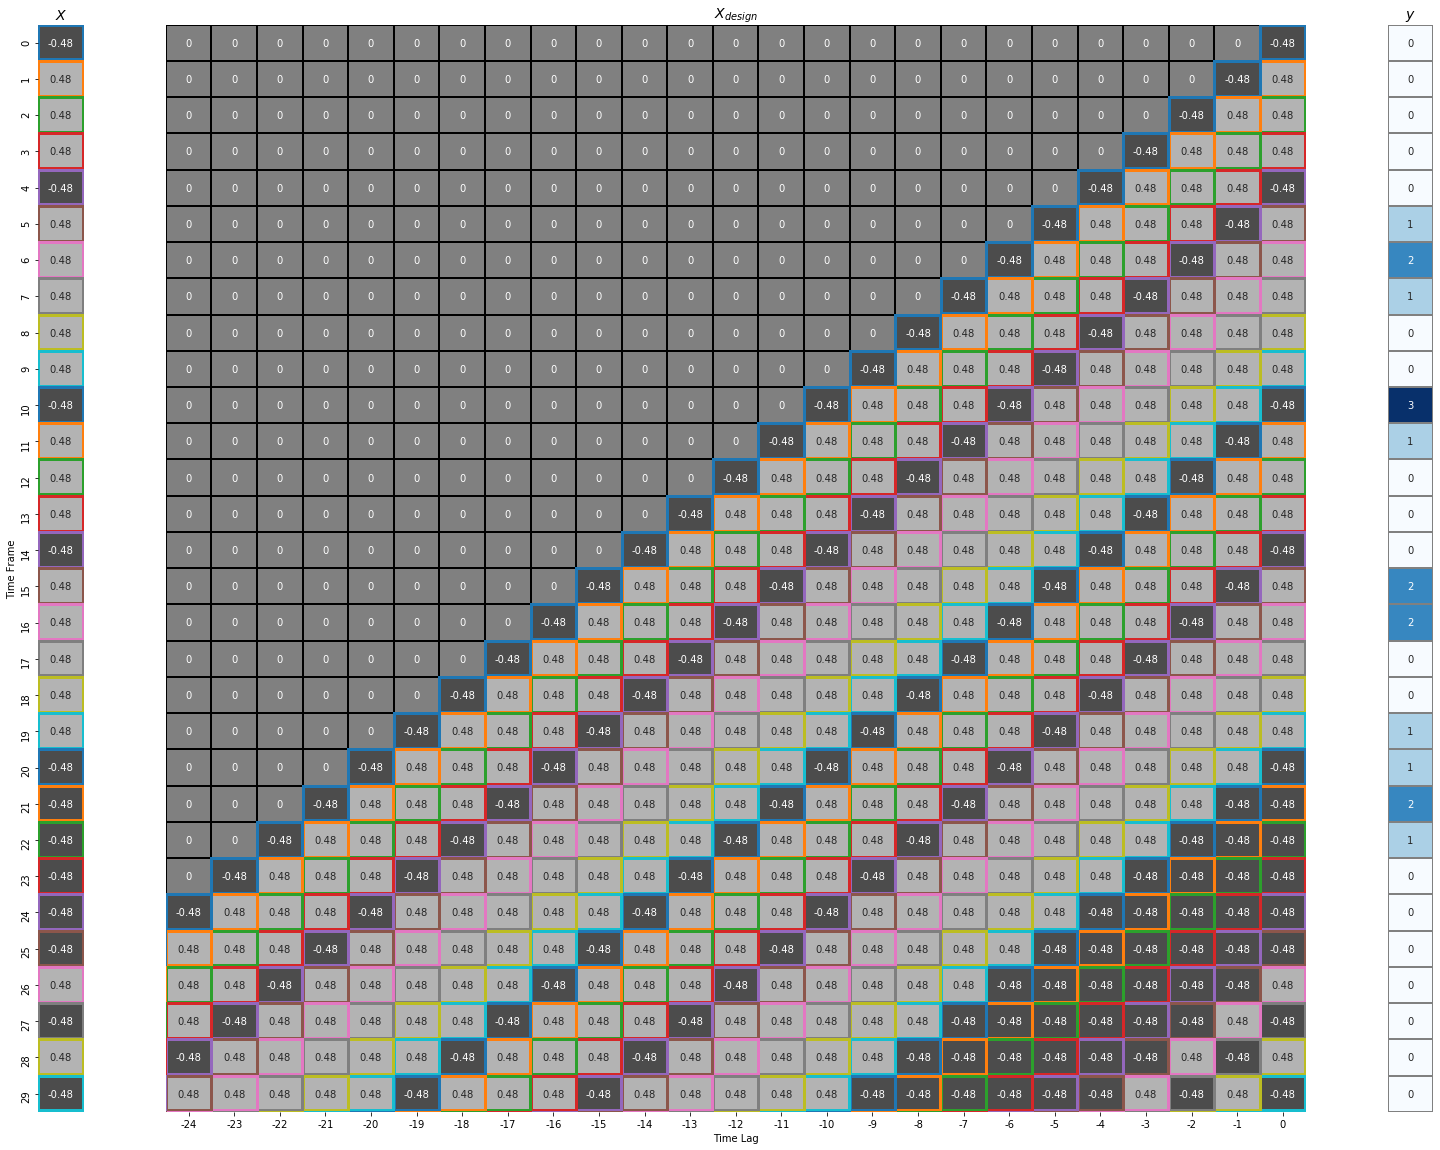

In [17]:
fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 25, 1]}, figsize=(25, 20))
sns.heatmap(Ximg[:30, 0, 0][:, None], annot=True, cmap='binary_r', linewidths=1, linecolor='white', cbar=False, 
            ax=ax[0], xticklabels=False, yticklabels=True, vmax=1.2, vmin=-1.2)
sns.heatmap(Xdsgn[:30, :], annot=True, cmap='binary_r', linewidths=1, linecolor='black', cbar=False, 
            ax=ax[1], xticklabels=np.arange(-24, 1), yticklabels=False, vmax=1.2, vmin=-1.2)
sns.heatmap(y[:30][:, None], annot=True, cmap=plt.cm.Blues, linewidths=1, linecolor='gray', cbar=False, 
            ax=ax[2], xticklabels=False, yticklabels=False)

ax[0].set_ylabel('Time Frame')
ax[0].set_title(r'$X$', fontsize=14)
ax[1].set_title(r'$X_{design}$', fontsize=14)
ax[2].set_title(r'$y$', fontsize=14)
ax[1].set_xlabel('Time Lag')

for i, (xi, yi) in enumerate([[k, 0] for k in range(30)]):
#     print(i, xi, yi)
    rect = patches.Rectangle((yi, xi), 1-0.01, 1-.04, linewidth=3, edgecolor=f'C{i}', facecolor='none')
    ax[0].add_patch(rect)
    
for j in range(30):
    for i, (xi, yi) in enumerate([[k, 0] for k in range(30)]):
        rect = patches.Rectangle((yi+24-j, xi+j), 1-0.01, 1-0.04, linewidth=3, edgecolor=f'C{i}', facecolor='none', zorder=10)
        ax[1].add_patch(rect)

### Visualizing the receptive field computed by spike-triggered average (STA)

$$w_{STA} = \frac{1}{n}X^{T}y$$

In [18]:
def compute_STA(X, y, dims):
    
    if len(X.shape) == 1:
        X = X[:, None]
        
    if len(y.shape) == 1:
        y = y[:, None]
    
    n_spikes = np.sum(y)
    w_STA = X.T @ y / n_spikes
    
    return w_STA.reshape(dims)

In [19]:
Xdsgn = build_design_matrix(X[:, None], 25)
w_sta = compute_STA(Xdsgn, y, dims=[25, ])

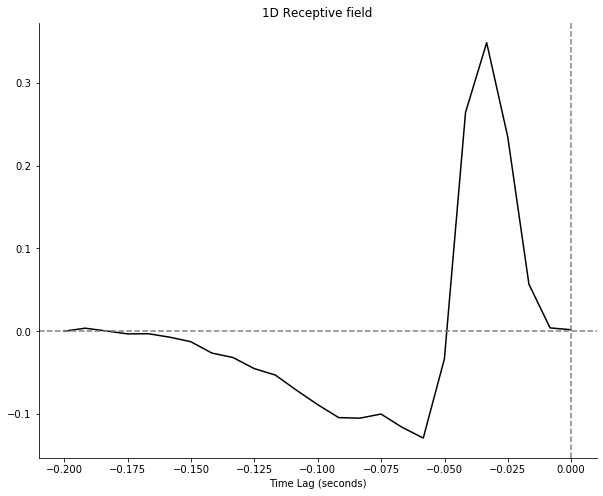

In [20]:
tt = np.arange(-25+1, 1) * dt

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(tt, w_sta, color='black')
ax.axhline(0, color='gray', linestyle='--')
ax.axvline(0, color='gray', linestyle='--')

ax.set_xlabel('Time Lag (seconds)')
ax.set_title('1D Receptive field')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 2D RF Example (Rust, et al., 2005)

In [21]:
data2d = fetch_data(1)

(Rust, et al., 2005) is already downloaded. To re-download the same file, please set `overwrite=False`.
Loading data...
Done.


In [22]:
X = data2d['stim'].T
y = data2d['spikes_per_frm']

The best thing about this dataset is that the X and y are already aligend.

In [23]:
(X.shape[0] == y.shape[0]), X.shape, y.shape

(True, (294912, 24), (294912, 1))

### visualizing the Flicker bars stimulus

In [24]:
def convert_stim2d(X, dims):
    n_samples = X.shape[0]
    X_addy = np.repeat(X, dims[1], axis=1).reshape(n_samples, dims[0], dims[1])
    return X_addy

In [25]:
Ximg = convert_stim2d(X, dims=[24, 24])

In [80]:
animate(Ximg[:20], dt=0.25, cmap=plt.cm.binary, reverse=False)

### Visualizing the stimulus design matrix

In [27]:
Xdsgn = build_design_matrix(X[:24, :24], 5)

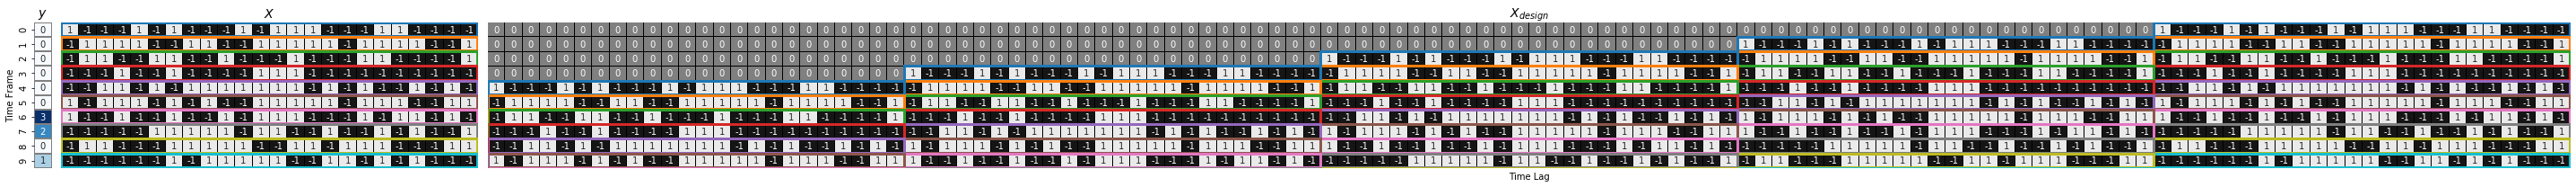

In [28]:
fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 24, 24*5]}, figsize=(40, 3))
sns.heatmap(y[:10], annot=True, cmap=plt.cm.Blues, linewidths=1, linecolor='gray', cbar=False, 
            ax=ax[0], xticklabels=False, yticklabels=True)

sns.heatmap(X[:10], annot=True, cmap='binary_r', linewidths=0.01, linecolor='black', cbar=False, 
            ax=ax[1], xticklabels=False, yticklabels=False, vmax=1.2, vmin=-1.2)

sns.heatmap(Xdsgn[:10, :], annot=True, cmap='binary_r', linewidths=0.01, linecolor='black', cbar=False, 
            ax=ax[2], xticklabels=False, yticklabels=False, vmax=1.2, vmin=-1.2)

ax[0].set_title(r'$y$', fontsize=14)
ax[0].set_ylabel('Time Frame')
ax[1].set_title(r'$X$', fontsize=14)
ax[2].set_title(r'$X_{design}$', fontsize=14)
ax[2].set_xlabel('Time Lag')

fig.tight_layout()
for i, (xi, yi) in enumerate([[k, 0] for k in range(10)]):
    rect = patches.Rectangle((yi, xi), 24-0.05, 1-.05, linewidth=3, edgecolor=f'C{i}', facecolor='none')
    ax[1].add_patch(rect)

for j in range(10):
    for i, (xi, yi) in enumerate([[k, 0] for k in range(10)]):
        rect = patches.Rectangle((yi+24*4-24*j, xi+j), 24-0.01, 1-0.04, linewidth=3, edgecolor=f'C{i}', facecolor='none', zorder=10)
        ax[2].add_patch(rect)

### Visualizing the receptive field computed by spike-triggered average (STA)

In [29]:
Xdsgn = build_design_matrix(X, 16)

In [30]:
dims = [16, 24]
w_sta_2d = compute_STA(Xdsgn, y, dims)

Text(0.5, 0, 'Time Lag')

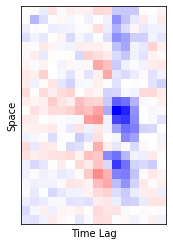

In [31]:
vmax = np.max([np.abs(w_sta_2d.min()), w_sta_2d.max()])

fig, ax = plt.subplots()
ax.imshow(w_sta_2d.T, cmap=plt.cm.bwr, vmin=-vmax, vmax=vmax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Space')
ax.set_xlabel('Time Lag')

### spike-triggered covariance

In [32]:
def compute_STC(X, y, w_sta):

    n = len(X)
    ste = X[y!=0] # spike-triggered ensemble
    
    proj = ste - ste * w_sta * w_sta.T
    stc = proj.T @ proj / (n - 1)

    eigvec, eigval, _ = np.linalg.svd(stc)

    return eigvec, eigval

In [33]:
w_stc, w_stc_eigval = compute_STC(Xdsgn, y.flatten(), w_sta_2d.flatten())

In [34]:
w_stc.shape, w_stc_eigval.shape

((384, 384), (384,))

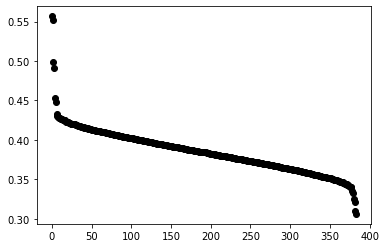

In [35]:
plt.plot(w_stc_eigval, 'ko')

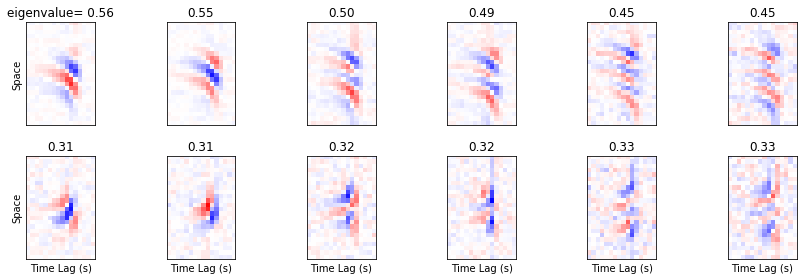

In [36]:
tt = np.arange(-16+1, 1) * dt
vmax = np.max([np.abs(w_stc.min()), w_stc.max()])

fig, ax = plt.subplots(2, 6, figsize=(12, 4))
for i in range(6):
    ax[0, i].imshow(w_stc[:, i].reshape(dims).T, vmin=-vmax, vmax=vmax, cmap=plt.cm.bwr)
    
    ax[0, i].set_title(f'{w_stc_eigval[i]:.2f}')
#     ax[0, i].set_xlabel('Time Lag (s)')
    
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    
    
    if i == 0:
        ax[0, i].set_title(f'eigenvalue= {w_stc_eigval[i]:.2f}')
        ax[0, i].set_ylabel('Space')
for j in range(6):
    ax[1, j].imshow(w_stc[:, -j-1].reshape(dims).T, vmin=-vmax, vmax=vmax, cmap=plt.cm.bwr)
    ax[1, j].set_title(f'{w_stc_eigval[-j-1]:.2f}')
    ax[1, j].set_xlabel('Time Lag (s)')
    if j == 0:
        ax[1, j].set_ylabel('Space')
    ax[1, j].set_xticks([])
    ax[1, j].set_yticks([])    

fig.tight_layout()

# 3D example (Ran, et al. 2020)

In [37]:
data3d = fetch_data(5)

(Ran, et al. 2020) is already downloaded. To re-download the same file, please set `overwrite=False`.
Loading data (Ran, et al. 2020)...
Done.


In [38]:
X = data3d['stim']
trace = data3d['C3']['cal']['soma']['trace'][:-10]
tracetime = data3d['C3']['cal']['soma']['tracetime'][:-10]
triggertime = data3d['C3']['cal']['soma']['triggertime']

In [39]:
X.shape, triggertime.shape, trace.shape, tracetime.shape

((1500, 20, 15), (1500,), (9990,), (9990,))

In [83]:
animate(X[:20], dt=0.25, figsize=(6, 6), cmap=plt.cm.binary, reverse=False, vmin=0, vmax=1)

We are not going to visualize the stimulus design matrix because it is the same as the flicker bar example but with more columns.

### visualizing the Calcium signal

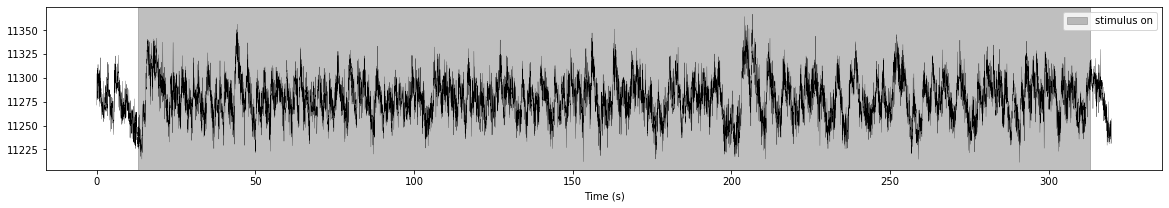

In [40]:
fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(tracetime, trace, color='black', linewidth=0.25)
ax.set_xlabel('Time (s)')
ax.axvspan(triggertime[0], triggertime[-1], color='gray', alpha=.5, label='stimulus on')
ax.legend()

In this example dataset, the stimulus is played at 5 Hz, while the sampling rate of the Calcium signal is 31.25 Hz. Again we have to make the stimulus and the response into the same shape, and we have two choices here: either we upsample the stimulus into the temporal resolution of the signal, or downsample the signal into the temporal resolution of the stimulus.

### downsampling the Calcium trace

It means that we would like to extract the exate value of the calcium trace at the time of each stimulus triggered time. We can use interpolation for this.

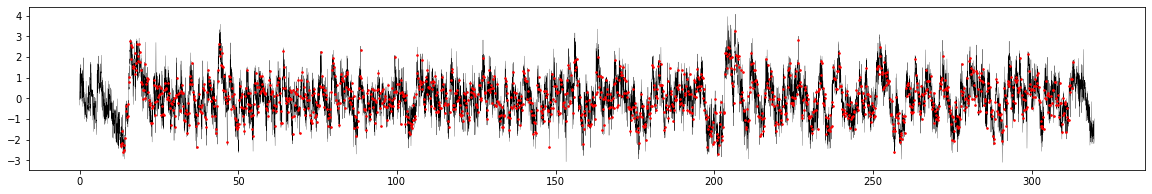

In [42]:
fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(tracetime, znorm(trace), color='black', linewidth=0.25)
ax.scatter(triggertime, y, color='red', s=2.5, zorder=3)


In [41]:
def znorm(x): # standardization
    return (x - x.mean()) / x.std()

from scipy.interpolate import interp1d

y = interp1d(
        tracetime.flatten(), 
        znorm(trace.flatten()),
        kind = 'linear', fill_value='extrapolate',
    ) (triggertime)


ygrad = np.gradient(y)
# For Ca2+ signal, we often use the gradient of the trace instead of the original one.
# It turns out that the gradient is more correlated with the firing rate. 
# see the supplementary Fig. 3 of Ran, Huang et al. (2020) for details.

In [43]:
X.shape, y.shape

((1500, 20, 15), (1500,))

In [44]:
dims = [5, 20, 15]
Xdsgn = build_design_matrix(X, 5)

In [45]:
w_sta_3d = compute_STA(Xdsgn, ygrad, dims)

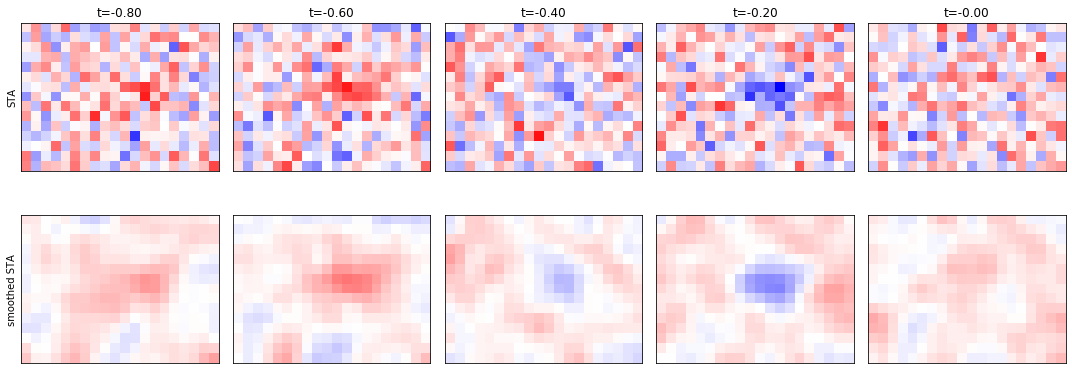

In [46]:
dt = 0.2
tt = np.arange(-0.8, dt, dt)
vmax = np.max([np.abs(w_sta_3d.min()), w_sta_3d.max()])

fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    ax[0, i].imshow(w_sta_3d[i].T, cmap=plt.cm.bwr, vmin=-vmax, vmax=vmax)
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[0, i].set_title(f't={tt[i]:.02f}')
    if i == 0:
        ax[0, i].set_ylabel('STA')

from scipy.ndimage import gaussian_filter    
for i in range(5):
    ax[1, i].imshow(gaussian_filter(w_sta_3d[i], 1).T, cmap=plt.cm.bwr, vmin=-vmax, vmax=vmax )
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
    if i == 0:
        ax[1, i].set_ylabel('smoothed STA')
    
fig.tight_layout()

### upsampling the stimulus

If the calcium is sampled at a higher rate than the stimulus (here is 31.25 Hz vs. 5Hz), you might want to upsample the stimulus instead so that you can also estimate the temporal profile of the RF more accurately.

In [47]:
from rfest.utils import upsample_data

In [48]:
Xup, y, dt = upsample_data(X, triggertime, trace, tracetime)

In [49]:
dims = [25, 20, 15]
Xdsgn = build_design_matrix(Xup, 25)

In [50]:
w_sta_3d = compute_STA(Xdsgn, y, dims)

In [100]:
w_sta_3d_smoothed = np.dstack([gaussian_filter(w_sta_3d[i], 1).T for i in range(len(w_sta_3d))]).T

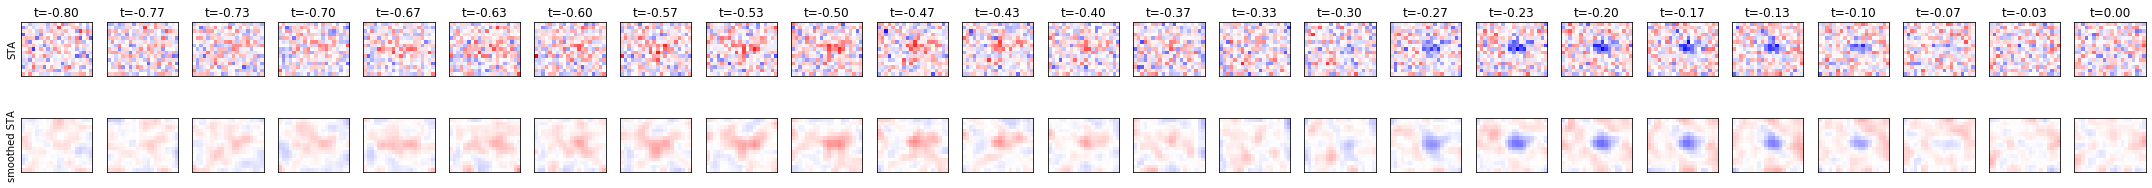

In [110]:
tt = np.linspace(-0.8, 0, 25)
vmax = np.max([np.abs(w_sta_3d.min()), w_sta_3d.max()])

fig, ax = plt.subplots(2, 25, figsize=(30, 3))
for i in range(25):
    ax[0, i].imshow(w_sta_3d[i].T, cmap=plt.cm.bwr, vmin=-vmax, vmax=vmax)
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[0, i].set_title(f't={tt[i]:.02f}')
    if i == 0:
        ax[0, i].set_ylabel('STA')

from scipy.ndimage import gaussian_filter    
for i in range(25):
    ax[1, i].imshow(w_sta_3d_smoothed[i].T, cmap=plt.cm.bwr, vmin=-vmax, vmax=vmax )
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
    if i == 0:
        ax[1, i].set_ylabel('smoothed STA')
    
fig.tight_layout()

In [112]:
vmax = np.max([np.abs(w_sta_3d.min()), w_sta_3d.max()])

animate(w_sta_3d, dt=0.25, vmax=vmax, vmin=-vmax, reverse=True)

In [111]:
vmax = np.max([np.abs(w_sta_3d_smoothed.min()), w_sta_3d_smoothed.max()])

animate(w_sta_3d_smoothed, dt=0.25, vmax=vmax, vmin=-vmax, reverse=True)

# Using RFest

In [52]:
(X_train, y_train), (X_dev, y_dev), (X_test, y_test) = split_data(Xup, np.maximum(0, gaussian_filter(y, sigma=2, truncate=0.25)), dt, 
                                                                  frac_train=0.75, frac_dev=0.25, verbose=1)

SUMMARY
               N    Minutes   Fraction
Total       9377        5.0        1.0
Train       7031       3.75       0.75
Dev         2344       1.25       0.25
Test           2        0.0        0.0


In [53]:
df = [7, 9, 7]
m = GLM(distr='gaussian', output_nonlinearity='none')
m.add_design_matrix(X_train, dims=dims, df=df, smooth='cr', filter_nonlinearity='none', name='stimulus') # light stimulus
m.add_design_matrix(X_dev, dims=dims, name='stimulus', kind='dev')
m.initialize({'train': y_train, 'dev': y_dev}, num_subunits=1, dt=dt, method='mle', random_seed=2046)


In [54]:
m.fit(num_iters=1000, beta=1.25, verbose=100)

Iters	  Time (s)	Cost (train)	Cost (dev)	corrcoef (train)	corrcoef (dev)
    0	     0.633	   125.074	    20.718	     0.059	    -0.001
  100	     1.391	    92.206	    19.060	     0.085	     0.008
  200	     2.107	    82.010	    18.116	     0.126	     0.024
  300	     2.820	    72.676	    17.452	     0.168	     0.042
  400	     4.572	    65.293	    17.048	     0.199	     0.052
  500	     6.066	    59.873	    16.817	     0.216	     0.055
  600	     7.710	    56.465	    16.578	     0.222	     0.078
  700	     9.416	    54.383	    16.378	     0.223	     0.111
  800	    11.042	    53.343	    16.262	     0.223	     0.137
  900	    12.635	    52.934	    16.217	     0.223	     0.149
Stop: reached 1000 steps.
Total time elapsed: 14.313s.



In [55]:
from rfest.check import plot3d, plot3dn, plot3d_allframes

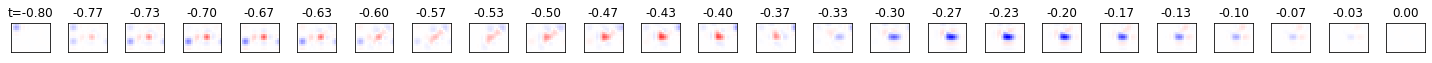

In [59]:
plot3d_allframes(m, figsize=(20, 4), transpose=True)

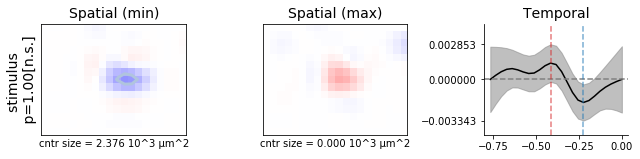

In [57]:
# plot 3d old which plots only the temporal profile from the most extremum pixel

plot3d(m, w_type='opt', figsize=(12, 4))

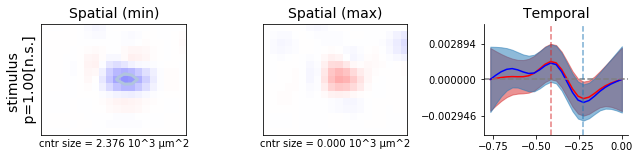

In [113]:
# plot 3d (new) which seperate the temporal filters from both max and min pixels

plot3dn(m, w_type='opt', figsize=(12, 4))

In [107]:
w_opt = m.w['opt']['stimulus'].reshape(dims)
vmax = np.max([np.abs(w_opt.min()), w_opt.max()])

animate(w_opt, dt=0.25, vmax=vmax, vmin=-vmax, reverse=True)